# Análise dos Resultados da Otimização dos Parâmetros

# Índice:
   * [Descrição](#description)
      * [Objetivos](#goals)
   * [Imports](#imports)
   * [Recuperação dos Dados do MLFlow](#recover)
       *[Modelos](#recoverModels)
       *[Resultados](#recoverResults)
   * [Análise](#analysis)
      * [Plot de Coordenadas Paralelas](#parallel)
      * [Plos de Desemepenho](#plotScore)
      * [Estrutura das Árvores](#treeStructure)
      * [Importância das Características](#featureImportance)
      * [p-valor](#pvalue)

## Descrição<a class="anchor" id="description"></a>

Esse notebook recupera os dados da busca de híper-parâmetros e analisa os resultados. São analisados o desempenho dos modelos nos testes, as estruturas de árvores com diferentes parâmetros e a importância das características utilizadas.

### Objetivos<a class="anchor" id="goals"></a>
   * Entender como os parâmetros de uma árvore de decisão influenciam sua estrutura e no seu desempenho no problema.
   * Apontar parâmetros ideais para o modelo baseado árvore de decisão para o problema.


## Imports

In [17]:
from time import time
from mlflow.tracking import MlflowClient
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
import mlflow
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Conexão com o MLflow

Para exeutar a conexão, é necessário passar o endereço de IP da máquina que hospeda o container que está rondando o MLflow. No bash, isso pode ser feito com $ip r.

In [2]:
client = MlflowClient(tracking_uri="http://172.27.0.1:5000")

## Funções Auxiliares

Nesta parte são defenidas funções para carregar os dados do MLflow, para imprimir esses dados, para carregá-los em um DataFrame, para selecioná-los e para plotar os resultados. 

In [3]:
# Recebe uma lista com experimentos (objetos da API MLflow) e imprime as infos de cada um.
def print_experiment_info(experiments):
    for e in experiments:
        print("- experiment_id: {}, name: {}, lifecycle_stage: {}"
              .format(e.experiment_id, e.name, e.lifecycle_stage))


In [4]:
# Recebe uma lista com runs (objetos da API MLflow) e imprime as infos de cada uma.
def print_run_infos(run_infos):
    for r in run_infos:
        print("- run_id: {}, lifecycle_stage: {}".format(r.run_id, r.lifecycle_stage))


In [5]:
def load_run_infos(run_infos):
    
    for r in run_infos:
        print("- run_id: {}, lifecycle_stage: {}".format(r.run_id, r.lifecycle_stage))


In [6]:
def load_runs(run_infos):
    parents = {}
    runs = []
    for run_info in run_infos:
        run_id = run_info.run_id
        run = client.get_run(run_id)
        data = run.data
        if "mlflow.parentRunId" in data.tags:
            parent = data.tags["mlflow.parentRunId"]
            if parent not in parents.keys():
                parents[parent] = client.get_run(parent)
            parent_data = parents[parent].data
            model = parent_data.params["model"]
            data.params["model"] = model
            runs.append(data.metrics | data.params )
    df = pd.DataFrame(runs)
    return df

    

In [ ]:
predicted_actual = {
    "True values": y_val, "Predicted values": gridPredictionVal}
predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
a_ = plt.title("Decision Tree Model\nPrediction vs Observed")

In [1]:
def connectMLFlow(MLFlowAddr):
    client = MlflowClient(tracking_uri=MLFlowAddr)
    mlflow.set_tracking_uri(MLFlowAddr)
    return client

In [2]:
def logCVResultsCSV(cv_results, run_id, mlclient ):

    tempdir = tempfile.TemporaryDirectory(suffix=None, prefix=None, dir=None)
    tmpname = tempdir.name
    
    filename = "cv_results.csv"
    csv = os.path.join(tmpname, filename)
    
    cv_results = gsCV.cv_results_
    pd.DataFrame(cv_results).to_csv(csv, index=False)
    
    mlflow.log_artifact(csv)
    tempdir.cleanup()


In [6]:
def recoverResultsCSV(uri):
    tempdir = tempfile.TemporaryDirectory()
    tmpname = tempdir.name


    file = mlflow.artifacts.download_artifacts(uri, dst_path=tmpname)
    results_df = pd.read_csv(file+"/cv_results.csv")
    tempdir.cleanup()
    return results_df

In [5]:
client = connectMLFlow("http://172.27.0.1:5000")

In [ ]:
experiment_name = "HiperParameter Search"
run_name = "DecisionTree GridSearch_artifact_test"

In [11]:
run = client.search_runs(61)[0]

In [12]:
uri = run.info.artifact_uri

In [15]:
uri

's3://mlflow/61/47478f2670cb45d6a47ccccaaa8afba7/artifacts'

In [20]:
results = recoverResultsCSV(uri+"/cv_results")

In [21]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_r2,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,0.031398,0.040328,0.002153,0.000660,515,245,6,11,"{'min_samples_split': 515, 'min_samples_leaf':...",0.256051,...,0.118052,157,-13.429497,-13.245963,-13.357340,-13.821844,-13.423523,-13.455634,0.194652,155
1,0.007753,0.000126,0.001760,0.000015,65,575,6,11,"{'min_samples_split': 65, 'min_samples_leaf': ...",0.212741,...,0.158558,403,-13.814875,-13.338728,-13.678229,-14.188707,-13.662922,-13.736692,0.274833,408
2,0.010743,0.000188,0.001792,0.000023,455,155,6,9,"{'min_samples_split': 455, 'min_samples_leaf':...",0.257672,...,0.109795,122,-13.414858,-13.198959,-13.271324,-13.765931,-13.456017,-13.421418,0.195931,103
3,0.008718,0.000412,0.001827,0.000072,95,455,6,11,"{'min_samples_split': 95, 'min_samples_leaf': ...",0.236008,...,0.161659,331,-13.609204,-13.321380,-13.561642,-14.069012,-13.520665,-13.616380,0.246621,321
4,0.009796,0.000099,0.001890,0.000186,65,35,6,5,"{'min_samples_split': 65, 'min_samples_leaf': ...",0.264881,...,0.036651,42,-13.349560,-13.271339,-13.153328,-13.570207,-13.329003,-13.334687,0.136108,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.011403,0.000883,0.003031,0.000422,35,365,6,13,"{'min_samples_split': 35, 'min_samples_leaf': ...",0.239349,...,0.125298,252,-13.579407,-13.293186,-13.421242,-13.921973,-13.485217,-13.540205,0.212357,256
496,0.007026,0.000352,0.002213,0.000238,5,365,6,3,"{'min_samples_split': 5, 'min_samples_leaf': 3...",0.209306,...,0.097605,397,-13.844981,-13.486697,-13.562941,-14.110724,-13.716700,-13.744408,0.221095,430
497,0.013378,0.000481,0.002272,0.000261,245,125,6,17,"{'min_samples_split': 245, 'min_samples_leaf':...",0.267394,...,0.107497,53,-13.326722,-13.156997,-13.304239,-13.535441,-13.480964,-13.360873,0.134785,51
498,0.008681,0.000497,0.002251,0.000282,245,575,6,15,"{'min_samples_split': 245, 'min_samples_leaf':...",0.212741,...,0.158558,403,-13.814875,-13.338728,-13.678229,-14.188707,-13.662922,-13.736692,0.274833,408


## Análise de um Experimento

Nessa parte faremos a análise de um dos experimentos executados. 

### Listando os experimentos

Primeiro são listadas as informações de todos os experimentos, facilitando a escolha do experimento a ser analisado.

In [7]:
print_experiment_info(client.list_experiments(view_type=ViewType.ALL))

- experiment_id: 0, name: Default, lifecycle_stage: active
- experiment_id: 1, name: script, lifecycle_stage: active
- experiment_id: 2, name: Logistic Regression IQA, lifecycle_stage: active
- experiment_id: 3, name: Multi Model Feature Exploration IQA, lifecycle_stage: active
- experiment_id: 4, name: CV tests, lifecycle_stage: active
- experiment_id: 5, name: test_nested, lifecycle_stage: active
- experiment_id: 24, name: GridSearch tests, lifecycle_stage: active
- experiment_id: 25, name: 24, lifecycle_stage: deleted
- experiment_id: 50, name: GridSearchCV, lifecycle_stage: active


### Escolha do experimento

A análise será feita no experimento GridSearchCV, de id = 50.

In [8]:
exp_id = 50
run_infos = client.list_run_infos(exp_id, run_view_type=ViewType.ALL)

### Analisando as runs

Podemos acessar as informações de uma run específica utilizando a função client.get_run(). Abaixo estão listadas as métricas de todas as runs do experimento. 

Cada conjunto de métricas está em um dicionário, e podemos fazer uma lista deles e contertê-la diretamente em um DataFrame.

In [38]:
df = load_runs(run_infos)
df

,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,mean_test_r2,std_test_neg_root_std_squared_error,std_test_neg_std_absolute_error,std_test_r2,folds,max_depth,max_features,min_samples_leaf,min_samples_split,who,model,fit_intercept,bootstrap,n_estimators
0,10.857736,14.044572,0.104652,0.463783,0.313482,0.025339,None,30,5,6,30,child,DecisionTreeRegressor,NaN,NaN,NaN
1,11.000817,14.205159,0.083445,0.333228,0.224040,0.030157,None,30,5,6,25,child,DecisionTreeRegressor,NaN,NaN,NaN
2,11.094233,14.432578,0.054055,0.329948,0.243152,0.023490,None,30,5,6,20,child,DecisionTreeRegressor,NaN,NaN,NaN
3,11.157118,14.525859,0.041808,0.488635,0.337579,0.040105,None,30,5,6,15,child,DecisionTreeRegressor,NaN,NaN,NaN
4,11.339181,14.688717,0.020762,0.534255,0.352129,0.031028,None,30,5,6,10,child,DecisionTreeRegressor,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,10.159429,12.822561,0.253650,0.395707,0.277951,0.018305,None,5,2,4,20,child,RandomForestRegressor,NaN,True,100
990,10.152291,12.818232,0.254161,0.388249,0.259482,0.016906,None,5,2,4,10,child,RandomForestRegressor,NaN,True,400
991,10.151350,12.815817,0.254443,0.381725,0.260896,0.015850,None,5,2,4,10,child,RandomForestRegressor,NaN,True,300
992,10.153010,12.815029,0.254500,0.380657,0.254950,0.017225,None,5,2,4,10,child,RandomForestRegressor,NaN,True,200


In [66]:
test_max_depth = df.groupby(['max_depth', 'model'], as_index=False)['mean_test_r2'].sum()

In [67]:
testTree = test_max_depth.loc[test_max_depth['model'] == "DecisionTreeRegressor"]
testForest = test_max_depth.loc[test_max_depth['model'] == "RandomForestRegressor"]

In [68]:
testTree = testTree.copy()
testForest = testForest.copy()

In [69]:
testTree["max_depth"] = testTree.max_depth.astype(int)
testForest["max_depth"] = testForest["max_depth"].astype(int)

In [70]:
testTree = testTree.sort_values(by="max_depth")
testForest = testForest.sort_values(by="max_depth")

<AxesSubplot:>

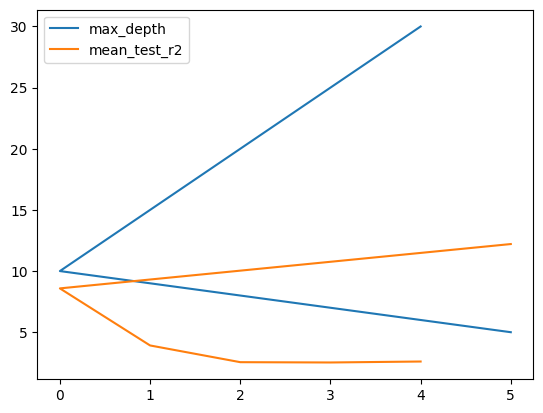

In [71]:
testTree.plot()

<AxesSubplot:>

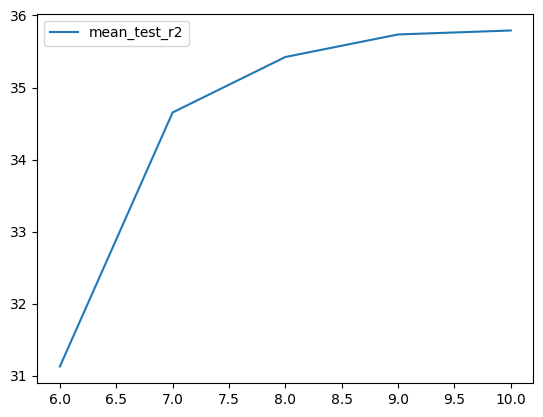

In [17]:
testForest.plot()

<function matplotlib.pyplot.show(close=None, block=None)>

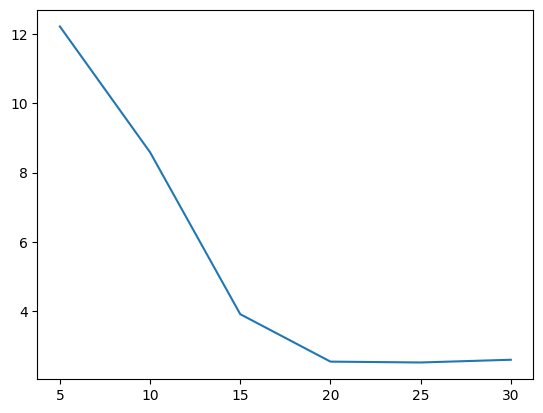

In [72]:
x = testTree["max_depth"]
y = testTree["mean_test_r2"]

plt.figure()
plt.plot(x,y)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

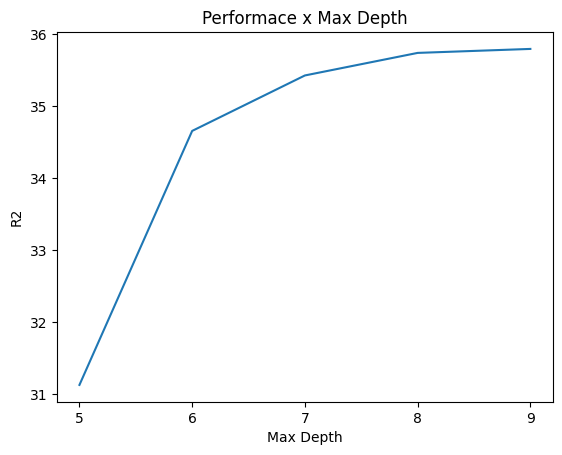

In [77]:
x = testForest["max_depth"]
y = testForest["mean_test_r2"]

plt.figure()
plt.plot(x,y)
plt.xlabel("Max Depth")
plt.ylabel("R2")
plt.title("Performace x Max Depth")
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show

## Importância das Características <a class="anchor" id="featureimportance"></a>


In [ ]:
results = mlflow.artifacts

In [ ]:
gsCV.best_estimator_.feature_importances_

In [22]:
cvresults = results
column_results = [
    f"param_{name}" for name in param_grid.keys()]
column_results += [
   "mean_test_r2"]
#, "std_test_r2", "rank_test_r2"]

cv_results = pd.DataFrame(gsCV.cv_results_)

cv_results = cv_results[column_results]

def shorten_param(param_name):
    if "param_" in param_name:
        return param_name.rsplit("param_", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1).apply({shorten_param(k):lambda x:x for k in column_results} )
cv_results

NameError: name 'param_grid' is not defined

In [ ]:
import plotly.express as px

fig = px.parallel_coordinates(
    cv_results[["max_depth",  "min_samples_split","mean_test_r2","min_samples_leaf"]],
    color="mean_test_r2",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

In [ ]:
gsCV.best_params_